* 개선을 위한 방법
1. 마지막엔 test을 나누지말고 그냥 전부 train 시켜버린다
2. 쓸데 없는 열을 버려본다?
3. 앙상블 모델을 써볼까?

In [1]:
import pandas as pd
import numpy as np
import joblib
import math
from keras.models import load_model

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기 및 파악

In [2]:
# 데스크탑
df = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

# 노트북
# df = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

In [3]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

In [4]:
# # 시간
# df['year'].value_counts() # 년도
# df['month'].value_counts() # 월
# df['day'].value_counts() # 일
# df['time'].value_counts() # 시간(0~23)
# df['minute'].value_counts() # 분(10분 단위)
# df['stn_id'].value_counts() # 지점 번호

# -99 있음
# df['ws10_deg'].value_counts() # 10분 평균 풍향, 단위 : deg
# df['ws10_ms'].value_counts() # 10분 평균 풍속, 단위 : m/s
# df['ta'].value_counts() # 1분 평균 기온 10분 주기, 단위 : C
# df['re'].value_counts() # 강수 유무(0:무강수, 1:강수)
# df['hm'].value_counts() # 1분 평균 상대 습도 10분 주기, 단위 : %
# df['sun10'].value_counts() # 1분 일사량 10분 단위 합계, 단위 : MJ
# df['ts'].value_counts() # 1분 평균 지면온도 10분 주기, 단위 : C
# df['vis1'].value_counts() # 1분 평균 시정 10분 주기, 단위 : C(test데이터 셋엔 없음)
# df['class'].value_counts() # 시정 구간

# 파생변수

# 2. 문자열 데이터 정리

## 2-1. year열 I,J,K 순으로 0,1,2로 맵핑

In [5]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'].value_counts()
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})

## 2-2. 20개 지점을 5개의 지역으로 수치화

In [6]:
# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
# 원하는 순서대로 레이블을 숫자로 매핑하는 딕셔너리 생성
stn_id_mapping = {v: k for k, v in enumerate(['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 
                                              'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'DA', 'DB', 
                                              'DC', 'EA', 'EB', 'EC'])}
# stn_id 열에 대해 딕셔너리를 적용하여 숫자로 변환
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

# 3. 독립변수 결측치 처리

In [7]:
# 방법2 : -99.9를 NA 처리후 선형보간법
# df에서 변수들 -99 NA처리
# 변환할 열 리스트
numeric_cols = ['stn_id', 'ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[numeric_cols] = df[numeric_cols].replace(-99.9, np.nan)

# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
region      0
dtype: int64


# 4. 이상치 처리

In [8]:
# 인덱스 안쓰는 방식으로 수정
features = df.columns.difference(['year', 'month', 'day', 'time','minute', 'stn_id', 're', 'vis1', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = (data > ucl) | (data < lcl)
        df.loc[outliers, feature] = np.nan
        df[feature] = df[feature].interpolate(method='linear')  # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

df = detect_outliers(df,features)

# 6. class 결측치 채우기

**파생변수**

In [9]:
# 모델 돌리기 위해 계절별 MINMAX를 해야함
# 그럴라면 파생변수 season이 필요

# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)


## 6-1. xgr를 활용하여 vis1 결측값 예측한 후, 해당 예측값을 결측값을 대체

In [10]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region,season
1,0,1,1,0,10,0,0.0,0.00,-6.4,0.0,38.9,0.0,-2.8,20000,4,0,3
2,0,1,1,0,20,0,0.0,0.00,-6.3,0.0,37.9,0.0,-2.7,20000,4,0,3
3,0,1,1,0,30,0,0.0,0.00,-6.3,0.0,40.0,0.0,-2.6,20000,4,0,3
4,0,1,1,0,40,0,27.8,0.40,-6.2,0.0,39.5,0.0,-2.6,20000,4,0,3
5,0,1,1,0,50,0,59.7,0.50,-6.1,0.0,39.8,0.0,-2.5,20000,4,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,19,305.3,6.15,2.5,0.0,50.2,0.0,-0.9,20000,4,4,3
3156456,2,12,31,23,20,19,293.8,5.70,2.3,0.0,50.1,0.0,-1.3,20000,4,4,3
3156457,2,12,31,23,30,19,274.2,4.90,2.2,0.0,51.0,0.0,-1.4,20000,4,4,3
3156458,2,12,31,23,40,19,270.3,4.60,2.1,0.0,51.7,0.0,-1.6,20000,4,4,3


In [11]:
# df_xgr 데이터프레임을 복사하여 사용합니다. 'class'는 초기에 'XGR'로 채워져 있다고 가정합니다.
df_xgr = df.copy()

# 클래스 분포를 확인하는 함수를 정의합니다.
def count_classes(df):
    return df['class'].value_counts()

In [12]:
# 초기 클래스 분포를 저장합니다.
initial_class_counts = count_classes(df_xgr)

# 'vis1'이 결측치가 아닌 행과 결측치인 행을 구분합니다.
train_data = df_xgr[df_xgr['vis1'] != -99]
test_data = df_xgr[df_xgr['vis1'] == -99]

# 'vis1'과 'class'를 제외한 열을 feature로 선택합니다.
features = df_xgr.columns.difference(['vis1', 'class'])

# train 데이터의 feature와 target을 분리합니다.
X_train = train_data[features]
y_train = train_data['vis1']

# test 데이터의 feature를 선택합니다.
X_test = test_data[features]

In [13]:
# 실제 수치형 데이터만 포함하는 리스트를 생성합니다.
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 계절을 반영한 MINMAX 스케일러 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

# train 데이터를 기반으로 스케일러를 학습하고, train과 test 데이터 모두에 스케일링을 적용합니다.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용합니다.
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    train_mask = X_train_scaled['season'] == season_value
    test_mask = X_test_scaled['season'] == season_value
    if train_mask.sum() > 0:
        X_train_scaled.loc[train_mask, numeric_features] = minmax_scaler.fit_transform(X_train_scaled.loc[train_mask, numeric_features])
    if test_mask.sum() > 0:
        X_test_scaled.loc[test_mask, numeric_features] = minmax_scaler.transform(X_test_scaled.loc[test_mask, numeric_features])

In [14]:
# XGBoost 회귀 모델을 학습하고 예측합니다.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)

# 예측된 값으로 test 데이터의 'vis1'의 결측치를 대체합니다.
test_data.loc[test_data['vis1'] == -99, 'vis1'] = y_pred[test_data['vis1'] == -99]

# 'vis1' 값을 기반으로 'class'를 분류하는 함수를 정의합니다.
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

# test 데이터에 대해 'class' 값을 예측합니다.
test_data.loc[test_data['class'] == -99, 'class'] = test_data.loc[test_data['class'] == -99, 'vis1'].apply(classify_visibility)

In [ ]:
# 전체 데이터프레임에 test 데이터의 변경 사항을 반영합니다.
df_xgr.update(test_data)

# 예측된 'vis1' 값을 기반으로 한 최종 'class' 분포를 계산합니다.
final_class_counts = count_classes(df_xgr)

# 초기 클래스 분포와 최종 클래스 분포를 계산하여 출력합니다.
print("초기 클래스 분포:\n", initial_class_counts)
print("최종 클래스 분포:\n", final_class_counts)

# 예측된 클래스 분포를 시각화합니다.
df_pred_class = pd.DataFrame({'y_pred': y_pred})
df_pred_class['pred_class'] = df_pred_class['y_pred'].apply(classify_visibility)

초기 클래스 분포:
  4     3101809
-99      22516
 3       12180
 2       12088
 1        7866
Name: class, dtype: int64
최종 클래스 분포:
 4.0    3124140
3.0      12226
2.0      12102
1.0       7991
Name: class, dtype: int64


c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\lib\

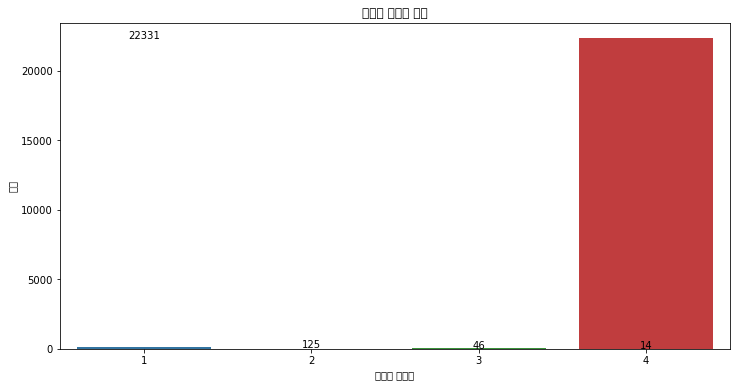

In [ ]:
# 예측된 클래스 분포를 막대 그래프로 나타냅니다.
plt.figure(figsize=(12, 6))
sns.barplot(x=df_pred_class['pred_class'].value_counts().index, y=df_pred_class['pred_class'].value_counts().values)
plt.title('예측된 클래스 분포')
plt.xlabel('예측된 클래스')
plt.ylabel('개수')

# 막대 위에 숫자를 표시합니다.
for index, value in enumerate(df_pred_class['pred_class'].value_counts().values):
    plt.text(index, value + 0.05, str(value), ha='center')

plt.show()

In [ ]:
# vis1 2000이상인 값은 2000으로 변경
df_xgr.loc[df_xgr['vis1'] >= 20000.0, 'vis1'] = 20000.0
df_xgr.loc[df_xgr['vis1'] <= 0.0, 'vis1'] = 0.0

## 6-2. 완성된 데이터 셋 저장

In [ ]:
# xgr

# 노트북
joblib.dump(df_xgr, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl')

# 데스크탑
# joblib.dump(df_xgr, "C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl")

['C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl']

# 7. VIS1 예측(회귀)

In [ ]:
# 노트북
# df_xgr = joblib.load('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl')
# 데스크탑
# df_xgr = joblib.load('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl')


In [ ]:
df = df_xgr.copy()

In [ ]:
df['vis1'].value_counts()

20000.000000    1107835
50000.000000     201606
18750.000000      11609
17647.000000      10327
50100.000000       9643
                 ...   
15536.769531          1
13035.532227          1
11313.062500          1
9945.875000           1
24951.083984          1
Name: vis1, Length: 72379, dtype: int64

In [ ]:
print(df[(df['vis1']!='20000.0')].shape)
print(df[(df['vis1']=='20000.0')].shape)

(3156459, 15)
(0, 15)


**파생변수** 

In [ ]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,0,1,1,0,10,0,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4
2,0,1,1,0,20,0,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4
3,0,1,1,0,30,0,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4
4,0,1,1,0,40,0,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4
5,0,1,1,0,50,0,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4
3156456,2,12,31,23,20,4,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4
3156457,2,12,31,23,30,4,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4
3156458,2,12,31,23,40,4,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4


In [ ]:
# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)

In [ ]:
# 이슬점(dew_point)
# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    # 상대 습도가 0이면 매우 낮은 값을 설정하여 log(0)가 발생하지 않도록 한다.
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

# 이슬점 계산하여 새로운 열 추가
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
# 풍향
# 풍향을 16방위로 변환하는 함수
def convert_wind_direction(wind_dir):
    # 22.5도 간격으로 16방위로 매핑
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction

# 풍향을 16방위로 변환하여 새로운 열에 추가
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)

# # 원-핫 인코딩을 위해 더미 변수 생성
# df = pd.get_dummies(df, columns=['wind_direction_16'], prefix='wind_dir')

In [ ]:
# 일교차(diurnal_range)
# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

In [ ]:
# 기온-이슬점(안개형성조건, 기온이 이슬점 이하일 때 잘 발생)
df['ts_dew_diff'] = df['ts'] - df['dew_point']

In [ ]:
# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group

# 각 stn_id별로 그룹화하여 함수 적용
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [ ]:
# 필요 없는 열 제거(시간 디테일 지역이라던가)

In [ ]:
df_pluscol = df.copy()

## 8-1. LSTM-1(양방향)

In [ ]:
df = df_pluscol.copy()

In [ ]:
df.columns

Index(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg',
       'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1', 'class', 'season',
       'dew_point', 'ws10_deg_16', 'diurnal_range', 'ts_dew_diff', '5_hm'],
      dtype='object')

In [ ]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,sun10,ts,vis1,class,season,dew_point,ws10_deg_16,diurnal_range,ts_dew_diff,5_hm
1,0,1,1,0,10,0,0.0,0.0,-6.4,0.0,...,0.0,-2.8,20000.0,4,3,-18.083476,0,15.147541,15.283476,38.90
2,0,1,1,0,20,0,0.0,0.0,-6.3,0.0,...,0.0,-2.7,20000.0,4,3,-18.299136,0,15.147541,15.599136,37.90
3,0,1,1,0,30,0,0.0,0.0,-6.3,0.0,...,0.0,-2.6,20000.0,4,3,-17.664937,0,15.147541,15.064937,40.00
4,0,1,1,0,40,0,27.8,0.4,-6.2,0.0,...,0.0,-2.6,20000.0,4,3,-17.722897,1,15.147541,15.122897,39.50
5,0,1,1,0,50,0,59.7,0.5,-6.1,0.0,...,0.0,-2.5,20000.0,4,3,-17.543307,3,15.147541,15.043307,39.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,305.3,7.7,2.5,0.0,...,0.0,-0.9,20000.0,4,3,-6.810493,14,28.100000,5.910493,50.06
3156456,2,12,31,23,20,4,293.8,5.7,2.3,0.0,...,0.0,-1.3,20000.0,4,3,-7.021146,13,28.100000,5.721146,50.16
3156457,2,12,31,23,30,4,274.2,4.9,2.2,0.0,...,0.0,-1.4,20000.0,4,3,-6.882689,12,28.100000,5.482689,50.36
3156458,2,12,31,23,40,4,270.3,4.6,2.1,0.0,...,0.0,-1.6,20000.0,4,3,-6.798347,12,28.100000,5.198347,50.66


In [ ]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = [ 'season', 're','ws10_deg_16',]
target = 'class'

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features + [target]]

In [ ]:
# # 원핫인코딩 안함 너무 오래 걸려 -> 라벨 인코딩으로
# # 인덱스를 확인하기 위해 원본 데이터프레임의 인덱스를 저장합니다.
# original_indices = data.index
# # 원핫 인코딩을 위한 OneHotEncoder 객체 생성
# onehot_encoder = OneHotEncoder(sparse=False)
# # 카테고리형 변수에 대해 원핫 인코딩을 적용
# encoded_categorical_data = onehot_encoder.fit_transform(data[categorical_features])
# # 원핫 인코딩된 결과를 데이터프레임으로 변환
# encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=onehot_encoder.get_feature_names_out(categorical_features))

In [ ]:
# # 인덱스를 확인하기 위해 원본 데이터프레임의 인덱스를 저장합니다.
# original_indices = data.index
# # 라벨 인코딩을 위한 LabelEncoder 객체 생성
# label_encoders = {feature: LabelEncoder() for feature in categorical_features}
# # 카테고리형 변수에 대해 라벨 인코딩을 적용
# encoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].fit_transform(x))
# # 인코딩된 카테고리형 변수와 원본 데이터프레임을 합침
# processed_data = pd.concat([data[numeric_features], encoded_categorical_data, data[target]], axis=1)

In [ ]:
# 계절을 반영한 Min-Max 스케일링
scaler = MinMaxScaler()
scaled_numeric_data = data.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.fit_transform(scaled_numeric_data.loc[mask, numeric_features])

# 숫자형 변수와 라벨 인코딩된 카테고리형 변수를 합침
processed_data = pd.concat([scaled_numeric_data[numeric_features], encoded_categorical_data, data[target]], axis=1)

In [ ]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].drop(columns=[target])
        label = data.iloc[i + sequence_length][target]
        sequences.append(seq.values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(processed_data, sequence_length)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=123)


KeyboardInterrupt: 

In [ ]:
# 양방향 LSTM 모델 구성
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, X_train.shape[-1])))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1, # 로그출력
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
31565/31565 [==============================] - 734s 23ms/step - loss: 242362864.0000 - val_loss: 198228736.0000
Epoch 2/100
31565/31565 [==============================] - 624s 20ms/step - loss: 161225792.0000 - val_loss: 127130288.0000
Epoch 3/100
31565/31565 [==============================] - 597s 19ms/step - loss: 100222392.0000 - val_loss: 76076120.0000
Epoch 4/100
31565/31565 [==============================] - 538s 17ms/step - loss: 59236236.0000 - val_loss: 44927848.0000
Epoch 5/100
31565/31565 [==============================] - 529s 17ms/step - loss: 38011996.0000 - val_loss: 33134252.0000
Epoch 6/100
31565/31565 [==============================] - 22858s 724ms/step - loss: 33263500.0000 - val_loss: 32545590.0000
Epoch 7/100
31565/31565 [==============================] - 528s 17ms/step - loss: 33178680.0000 - val_loss: 32543940.0000
Epoch 8/100
31565/31565 [==============================] - 541s 17ms/step - loss: 33179792.0000 - val_loss: 32544360.0000
Epoch 9/100
3156

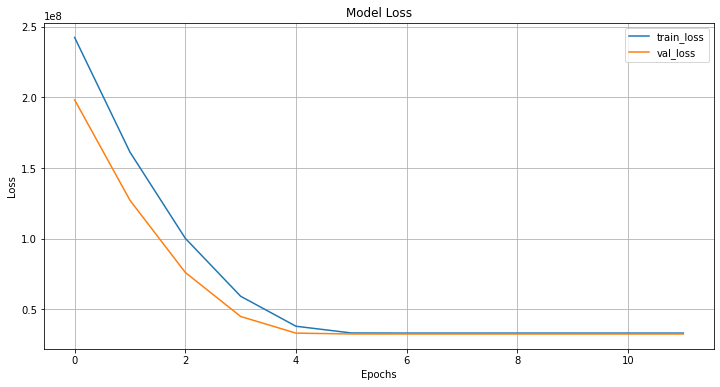

In [ ]:
# history 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 모델 평가
y_pred = model.predict(X_test)

19728/19728 [==============================] - 78s 4ms/step


In [ ]:
# 예측된 vis1을 바탕으로 class를 계산
def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred.flatten()])
y_test_class = np.array([classify_vis1(vis) for vis in y_test])

In [ ]:
# CSI 계산 예시 (필요에 따라 추가적으로 수행)
def calculate_csi(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    csi_values = []
    for i in range(1, 5):  # class 1 to 4
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        csi_values.append(csi)
    return np.mean(csi_values)

csi = calculate_csi(y_test_class, y_pred_class)
print(f'CSI: {csi}')

CSI: 0.2474868959006227


In [ ]:
#모델 저장
model.save('model_1.h5')

# 노트북
model.save('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\model_1.h5')

# 데스크탑
# model.save('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\model_1.h5')

c:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 전처리기 저장
joblib.dump(scaler, 'scaler_1.pkl')
joblib.dump(label_encoders, 'label_encoders_1.pkl')

# 노트북
joblib.dump(scaler, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\scaler_1.pkl')
joblib.dump(label_encoders, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders_1.pkl')

# # 데스크탑
# joblib.dump(scaler, 'C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\scaler.pkl')
# joblib.dump(label_encoders, 'C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders.pkl')

['C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\label_encoders_1.pkl']

### fog_test.csv을 예측 

In [ ]:
# 데스크탑
# df_test = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

# 노트북
df_test = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

In [ ]:
df_original = df_test.copy()
df = df_test.copy()

**기본 전처리**

In [ ]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

# year열 I, J, K 순으로 0, 1, 2로 맵핑 (현재 L만 있어서 0으로 맵핑)
df['year'] = df['year'].map({'L': 0})

# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
stn_id_mapping = {v: k for k, v in enumerate(['AI', 'BE', 'CC', 'DD'])}
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

In [ ]:
# 마지막 행이 결측열이길래 제거
df.loc[:, df.columns != 'class'] = df.loc[:, df.columns != 'class'].fillna(method='ffill')

**결측치 제거**

In [ ]:
# df에서 변수들 -99 NA처리
# 변환할 열 리스트
numeric_cols = ['stn_id', 'ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[numeric_cols] = df[numeric_cols].replace(-99.9, np.nan)
df['vis1','class'] = df['vis1','class'].replace(-99, np.nan)

# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

**이상치 제거**

In [ ]:
features = df.columns.difference(['year', 'month', 'day', 'time','minute', 'stn_id', 're', 'vis1', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    outliers_indices = {}
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = np.where((data > ucl) | (data < lcl))[0]
        outliers_indices[feature] = outliers
    return outliers_indices

# 이상치 탐지
outliers_indices = detect_outliers(df, features)

# 이상치 대체 함수 정의
def replace_outliers(df, outliers_indices):
    for feature, indices in outliers_indices.items():
        df.loc[indices, feature] = np.nan
        df[feature] = df[feature].interpolate(method='polynomial', order=2) # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

# 이상치 대체 수행
replace_outliers(df, outliers_indices)

**파생 변수**

In [ ]:
# 계절 매핑
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울
df['season'] = df['month'].apply(map_season)

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + np.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

# 풍향을 16방위로 변환
def convert_wind_direction(wind_dir):
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)

# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

# 기온-이슬점
df['ts_dew_diff'] = df['ts'] - df['dew_point']

# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [ ]:
# 각 열의 결측치 개수 확인
missing_values = df.isna().sum()
print("결측치 개수:")
print(missing_values)

결측치 개수:
year                  0
month                 0
day                   0
time                  0
minute                0
stn_id                0
ws10_deg              0
ws10_ms               0
ta                    0
re                    0
hm                    0
sun10                 0
ts                    0
class            166935
region                0
season                0
dew_point             0
ws10_deg_16           0
diurnal_range         0
ts_dew_diff           0
5_hm                  0
dtype: int64


**LSTM 적용부분**

In [ ]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're','ws10_deg_16',]

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features]

# 라벨 인코딩 및 스케일러 로드
label_encoders = joblib.load('label_encoders_1.pkl')
scaler = joblib.load('scaler_1.pkl')

# 카테고리형 변수에 대해 라벨 인코딩을 적용
encoded_categorical_data = data[categorical_features].apply(lambda x: label_encoders[x.name].transform(x))
processed_data = pd.concat([data[numeric_features], encoded_categorical_data], axis=1)


# 계절을 반영한 Min-Max 스케일링
scaled_numeric_data = processed_data.copy()
for season_value in range(4):
    mask = scaled_numeric_data['season'] == season_value
    if mask.sum() > 0:
        scaled_numeric_data.loc[mask, numeric_features] = scaler.transform(scaled_numeric_data.loc[mask, numeric_features])

processed_data = pd.concat([scaled_numeric_data[numeric_features], encoded_categorical_data], axis=1)


In [ ]:
processed_data['re'].value_counts()

1    156909
2      8079
0      3980
Name: re, dtype: int64

In [ ]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        sequences.append(seq.values)
    return np.array(sequences)

sequences_test = create_sequences(processed_data, sequence_length)

In [ ]:
sequences_test

array([[[9.15277778e-01, 2.62673864e-01, 5.19705225e-01, ...,
         3.00000000e+00, 1.00000000e+00, 1.50000000e+01],
        [8.93888889e-01, 2.67213278e-01, 5.19705225e-01, ...,
         3.00000000e+00, 1.00000000e+00, 1.40000000e+01],
        [1.11111111e-03, 2.61160726e-01, 5.19705225e-01, ...,
         3.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [8.98888889e-01, 2.63430433e-01, 5.17952325e-01, ...,
         3.00000000e+00, 1.00000000e+00, 1.40000000e+01],
        [5.78888889e-01, 2.59647588e-01, 5.17952325e-01, ...,
         3.00000000e+00, 1.00000000e+00, 9.00000000e+00],
        [2.81944444e-01, 2.58891019e-01, 5.16199424e-01, ...,
         3.00000000e+00, 1.00000000e+00, 5.00000000e+00]],

       [[8.93888889e-01, 2.67213278e-01, 5.19705225e-01, ...,
         3.00000000e+00, 1.00000000e+00, 1.40000000e+01],
        [1.11111111e-03, 2.61160726e-01, 5.19705225e-01, ...,
         3.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [8.98888889e-01, 2.63430433e-0

In [ ]:
# 모델 적용
model = load_model('model_1.h5')
y_pred = model.predict(sequences_test)

def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred.flatten()])

5281/5281 [==============================] - 33s 6ms/step


In [ ]:
# 필요한 열만 사용
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts',
                    'dew_point', 'diurnal_range', '5_hm']
categorical_features = ['region', 'season', 're','ws10_deg_16',]
target = 'vis1'

# 데이터프레임에서 필요한 열만 선택
data = df[numeric_features + categorical_features + [target]]

In [ ]:
y_pred

array([[16015.454],
       [16015.454],
       [16015.454],
       ...,
       [16015.454],
       [16015.454],
       [16015.454]], dtype=float32)

In [ ]:
# 예측 결과를 DataFrame에 추가
df_original['fog_test.class'].iloc[sequence_length:] = y_pred_class
df_original.loc[:, df_original.columns != 'class'] = df_original.loc[:, df_original.columns != 'class'].fillna(method='bfill')

# 예측 결과 출력 또는 저장
# print(df_original[['year', 'month', 'day', 'time', 'fog_test.class']])

# CSV로 저장
df_original.to_csv('predicted_results.csv', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_16168\24892146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_original['fog_test.class'].iloc[sequence_length:] = y_pred_class


In [ ]:
df_original['fog_test.class'].value_counts()

4.0    168968
Name: fog_test.class, dtype: int64

In [ ]:
# 노트북
df_original.to_csv('C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\predicted_results.csv', index=False)

# 데스크탑
# df_original.to_csv('C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\predicted_results.csv', index=False)